In [1]:
import sys
import os
path = os.getcwd()
dir = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(dir)

In [2]:
import numpy as np

In [3]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const

In [4]:
from plot.plot import plot_contour
import amplification_factor.amplification_factor as af

In [5]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

coordinates in scaled units [x (radians) /thetaE_tot]

In [6]:
y0, y1 = 0.5, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [7]:
mL1 = 100

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE = param_processing(zL, zS, mL1)

In [8]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE

In [9]:
lens_model_list = ['POINT_MASS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE}
kwargs_lens_list = [kwargs_sis_1]

In [10]:
kwargs_sis_1_scaled = {'center_x': eta10 / thetaE, 'center_y': eta11 / thetaE, 'theta_E': thetaE / thetaE}
kwargs_lens_list_scaled = [kwargs_sis_1_scaled]

In [11]:
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(eta10, eta11, kwargs_lens_list, beta0, beta1)#[0]
Tscale = 4 * (1 + zL) * mL1 * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))

T0 = 57.68962732485115
Tscale = 0.0029552946153261453


In [12]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE
               }

In [13]:
# Define the characteristic WindowSize
mL2 = 10
thetaE2 = param_processing(zL, zS, mL2)

kwargs_integrator = {'PixelNum': int(20000),          # Number of pixels on each side of the window
                     'PixelBlockMax': 2000,           # Dividing PixelNum into PixelBlock
                     'WindowSize': 210*thetaE2, 
                     'WindowCenterX': eta10, 
                     'WindowCenterY': eta11,
                     'T0': T0,                        # Time delay of the reference point (WindowCenter)
                     'TimeStep': 1e-5/Tscale,         # integration step in time domain
                     'TimeMax': T0 + 1/Tscale,        # Upper bound of time integration
                     'TimeMin': T0 - .1/Tscale,       # Lower bound of time integration
                     'TimeLength': 4/Tscale,          
                     'TExtend': 10/Tscale,            # Extend the time domain curve to desired time. In this example, it is extended to T0+10 seconds 
                     'Tscale': Tscale}                

bin 23.85205340535073 396.07213403463925
start


Integrating...: 100%|██████████| 121/121 [00:55<00:00,  2.16it/s]


0 1 110001
total time 13.99999


<Figure size 432x288 with 0 Axes>

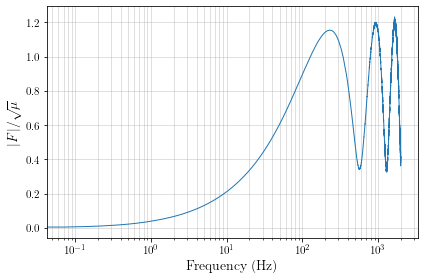

<AxesSubplot:xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [14]:
amplification = af.amplification_factor(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
ts, F_tilde = amplification.integrator(gpu=False)
ws, Fws = amplification.fourier()
amplification.plot_freq()

In [16]:
from lensinggw.solver.images import microimages

solver_kwargs = {'SearchWindowMacro': 10 * thetaE,
                 'SearchWindow': 5 * thetaE2,
                 'OverlapDistMacro': 1e-17,
                 'OnlyMacro': True}

MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                     source_pos_y=beta1,
                                                     lens_model_list=lens_model_list,
                                                     kwargs_lens=kwargs_lens_list,
                                                     **solver_kwargs)



---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> True
Scaled            --> False
SearchWindowMacro --> 8.052888061582409e-10
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-6.2875050e-11  1.0313949e-10]
dec: [-8.15724348e-26 -8.15724348e-26]



In [18]:
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle

Macromus = magnifications(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list)
T01 = TimeDelay(MacroImg_ra, MacroImg_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)

In [19]:
Macromus

array([-0.59141031,  1.59141031])

In [20]:
T01

array([0.0029858, 0.       ])

In [21]:
ns = getMinMaxSaddle(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list, diff = None)

In [31]:
ns = [0.5,0]

In [23]:
freq = np.linspace(10,2000,2000)

In [24]:
freq

array([  10.        ,   10.99549775,   11.9909955 , ..., 1998.0090045 ,
       1999.00450225, 2000.        ])

/home/manchun.yeung/microlensing/env/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


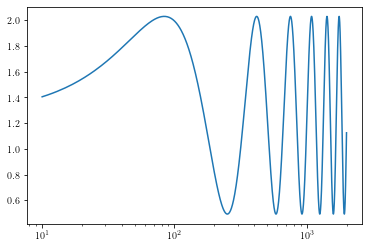

In [32]:
from lensinggw.amplification_factor.amplification_factor import amplification_from_data
Fmag = amplification_from_data(freq, Macromus, T01, ns)
import matplotlib.pyplot as plt
plt.semilogx(freq, Fmag)